# Classification of Identical data

The main objective of this project is to find out questions which are duplicate between different questions which are posted on several online forums like Quora, StackOverFlow, etc. The dataset which is used is taken from a kaggle competition: https://www.kaggle.com/c/quora-question-pairs 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Krupal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("~/Downloads/Quora_question_pairs/train.csv")
data = pd.read_csv("~/Downloads/Quora_question_pairs/train.csv")
#print("Number of data points:",df.shape[0])

In [59]:
df.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,freq_q1+q2,freq_q1-q2,word_Common,word_Total,...,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,q1_feats_m,q2_feats_m
0,1,1,66,57,14,12,2,0,10.0,23.0,...,0.0,1.0,2.0,13.0,100,93,93,100,"[-3.2677470296621323, 16.103518910706043, 3.01...","[0.39420346915721893, 13.775071926414967, -0.4..."
1,4,1,51,88,8,13,5,3,4.0,20.0,...,0.0,1.0,5.0,12.5,86,63,66,75,"[9.671892628073692, 12.217174671590328, 18.287...","[4.680233582854271, 9.616021618247032, 20.2182..."
2,1,1,73,59,14,10,2,0,4.0,24.0,...,0.0,1.0,4.0,12.0,66,66,54,54,"[1.1449431478977203, 15.836799167096615, -7.83...","[-16.654278740286827, 17.12190022878349, -8.70..."
3,1,1,50,65,11,9,2,0,0.0,19.0,...,0.0,0.0,2.0,12.0,36,36,35,40,"[-4.8139647650532424, 16.449952125549316, -15....","[-1.0688468888401985, 33.55321308225393, 24.73..."
4,3,1,76,39,13,7,4,2,2.0,20.0,...,0.0,1.0,6.0,10.0,67,47,46,56,"[-11.158065721392632, 19.90525422990322, -4.73...","[-5.422803372144699, 1.7079358100891113, 1.799..."


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Distribution of data among output classes

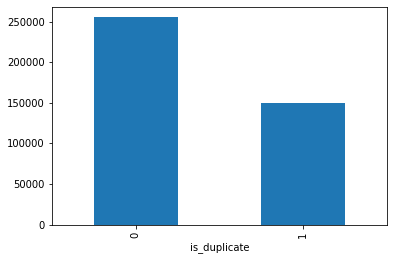

In [102]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [103]:
print('~> Total number of question pairs for training:   {}'.format(len(df)))

~> Total number of question pairs for training:   404290


In [104]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


## Number of unique questions 

In [151]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



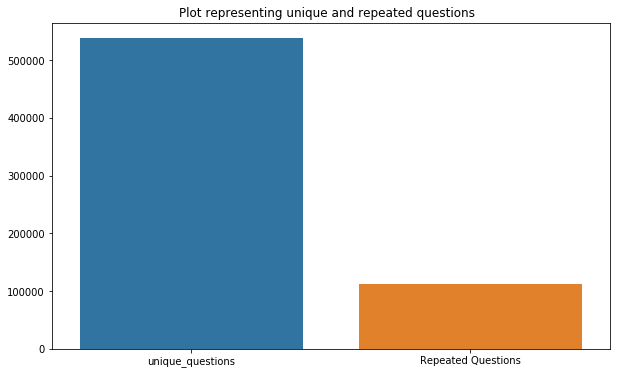

In [16]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

## Checking for duplicate pair of questions

In [17]:
#Checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Number of duplicate questions:",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions: 0


# Number of occurence of each question

Maximum number of times a single question is repeated: 157



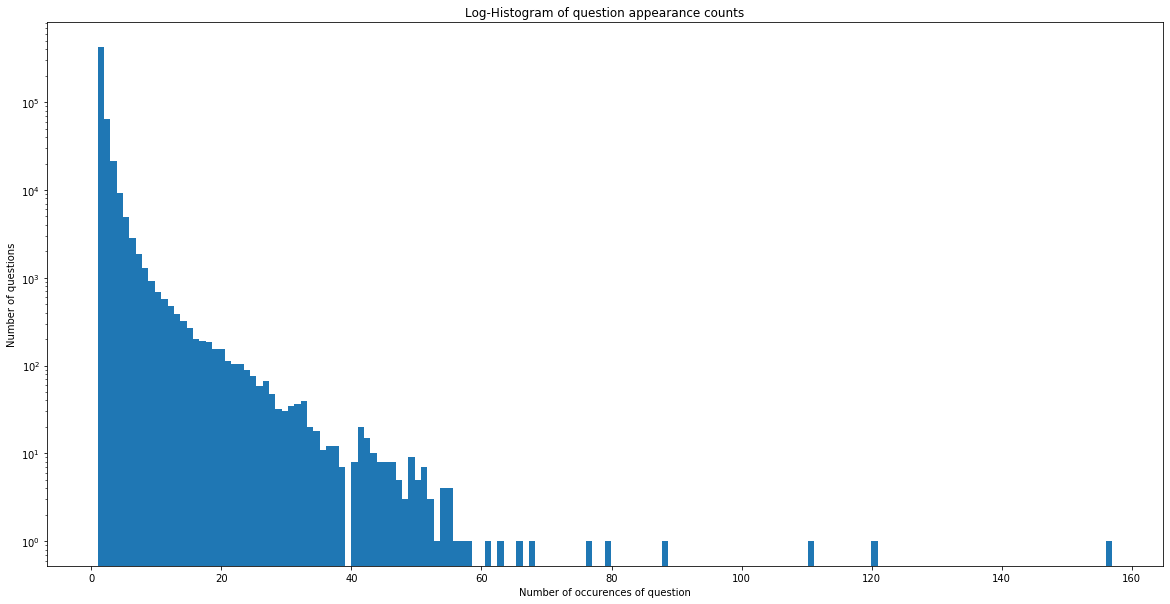

In [18]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [19]:
#CHecking for null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  \
105780                                                NaN             0   
201841                                                NaN             0   
363362  My Chinese name is Haichao Yu. What English na...             0   

        freq_qid1  freq_qid2  q1len  q2len  
105780          2          2   30.0    NaN  
201841          1          2   32.0    NaN  
363362          1          1    NaN  123.0  


In [3]:
#Since there are only 6 rows which has null values out of 404290, it would be ok to fill the null values with space
#Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## Basic feature extraction

In [4]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [5]:
def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

In [116]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,freq_q1+q2,freq_q1-q2,word_Common,word_Total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,2,0,10.0,23.0,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,5,3,4.0,20.0,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,2,0,4.0,24.0,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,2,0,0.0,19.0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,4,2,2.0,20.0,0.100000


## Analyzing features 

In [117]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


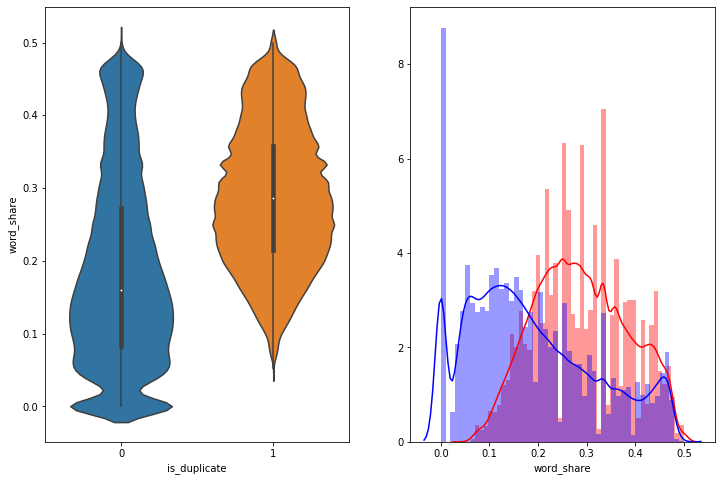

In [118]:
#Feature: word_share
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

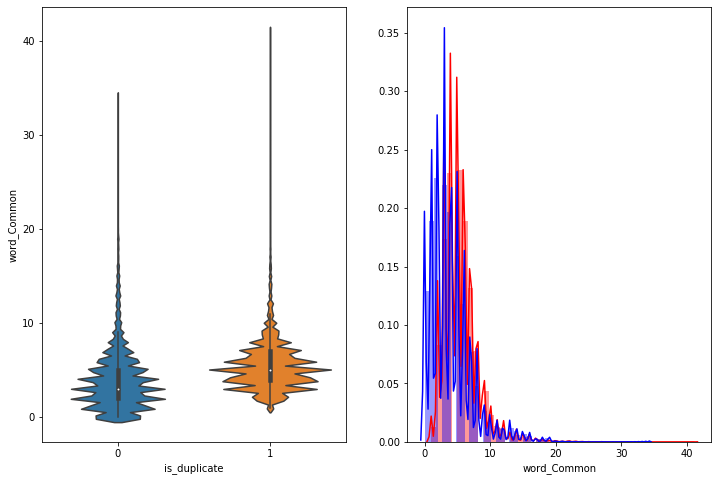

In [119]:
#Feature: Word_common
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

## Preprocessing text 

In [6]:
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [7]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features


def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [8]:
df = extract_features(df)

token features...
fuzzy features..


In [9]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75


# Analysis of extracted features
Plotting word clouds

In [71]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

In [72]:
# Converting 2d array of q1 and q2 and flatten the array
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

In [73]:
print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [75]:
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')

np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

In [76]:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()

In [78]:
stopwords = set(STOPWORDS)

Word Cloud for Duplicate Question pairs


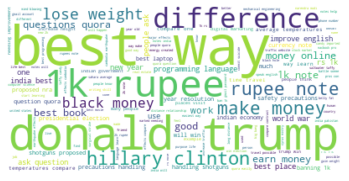

In [79]:
#Word Clouds generated from duplicate pair question's text 
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


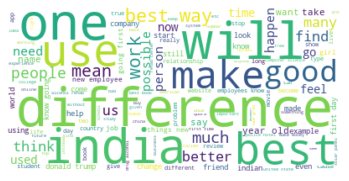

In [80]:
#Word Clouds generated from non-duplicate pair question's text 
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

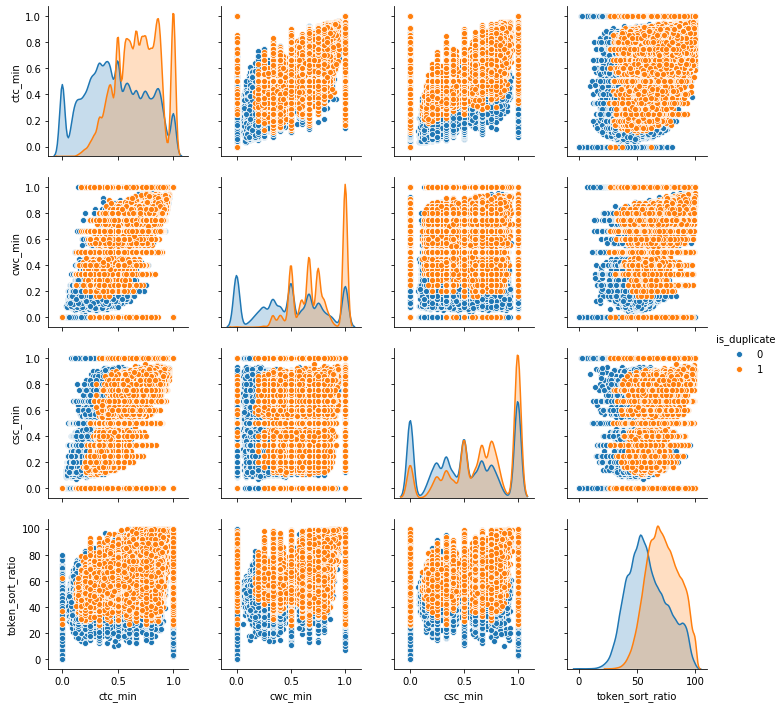

In [81]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

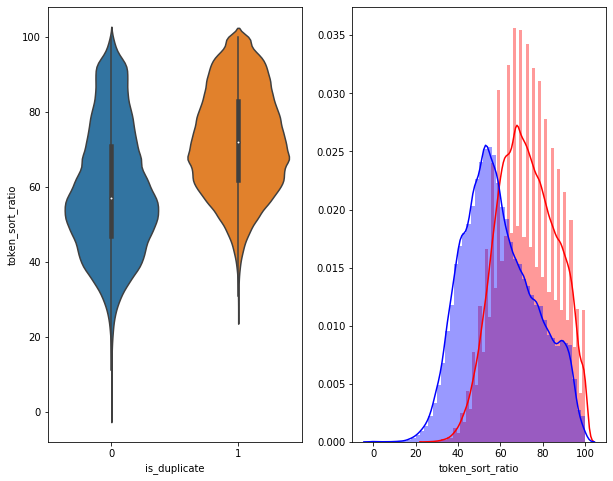

In [82]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

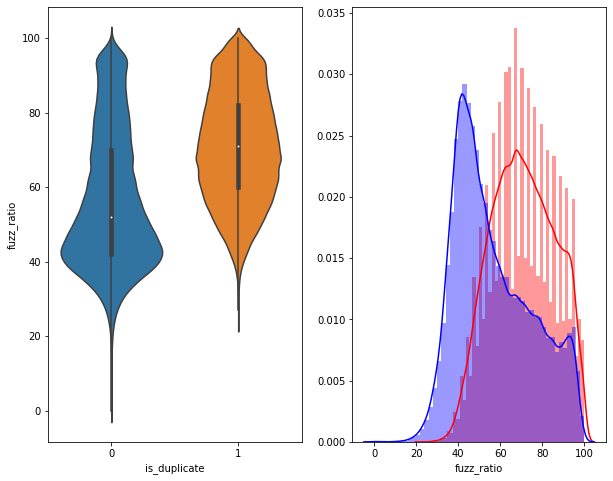

In [83]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

# Visualisation

In [175]:
# Using TSNE for Dimentionality reduction for 14 Features(Generated after cleaning the data) to 3 dimentions

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [86]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.019s...
[t-SNE] Computed neighbors for 5000 samples in 0.434s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.106532
[t-SNE] Computed conditional probabilities in 0.212s
[t-SNE] Iteration 50: error = 80.9083405, gradient norm = 0.0413686 (50 iterations in 3.491s)
[t-SNE] Iteration 100: error = 70.0210800, gradient norm = 0.0093216 (50 iterations in 2.082s)
[t-SNE] Iteration 150: error = 68.1011734, gradient norm = 0.0058354 (50 iterations in 2.047s)
[t-SNE] Iteration 200: error = 67.0342178, gradient norm = 0.0042820 (50 iterations in 2.111s)
[t-SNE] Iteration 250: error = 66.4954605, gradient norm = 0.0036381

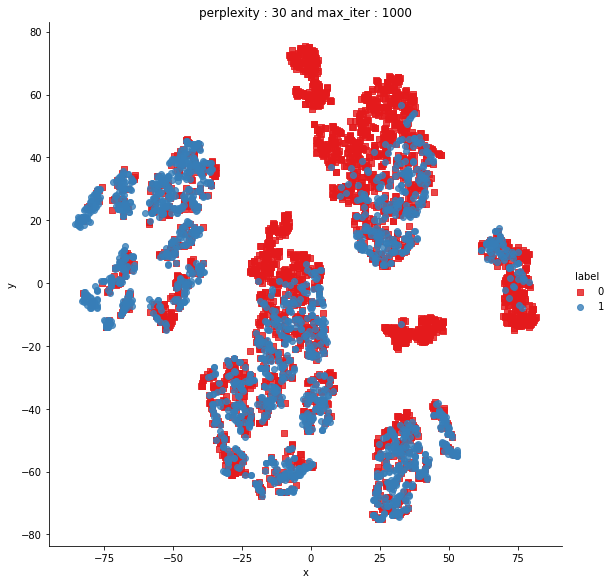

In [87]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [88]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.433s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.106532
[t-SNE] Computed conditional probabilities in 0.201s
[t-SNE] Iteration 50: error = 79.8853149, gradient norm = 0.0286003 (50 iterations in 9.918s)
[t-SNE] Iteration 100: error = 68.4899368, gradient norm = 0.0035794 (50 iterations in 5.632s)
[t-SNE] Iteration 150: error = 66.8920135, gradient norm = 0.0017835 (50 iterations in 5.199s)
[t-SNE] Iteration 200: error = 66.2732010, gradient norm = 0.0015295 (50 iterations in 5.119s)
[t-SNE] Iteration 250: error = 65.9232254, gradient norm = 0.0008926

# Featurizing text data with tfidf weighted word-vectors

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [11]:
word2tfidf

{'00': 10.196316891245568,
 '000': 11.46754192258067,
 '0001': 13.909888957949875,
 '0002': 13.909888957949875,
 '000k1': 13.909888957949875,
 '000k74': 13.909888957949875,
 '000s': 13.909888957949875,
 '000webhost': 13.50442384984171,
 '001': 12.811276669281765,
 '0015': 13.909888957949875,
 '0019': 12.99359822607572,
 '002': 13.21674177738993,
 '0021': 13.909888957949875,
 '0035': 13.909888957949875,
 '003sc': 13.909888957949875,
 '005': 13.909888957949875,
 '0051': 13.50442384984171,
 '007': 13.50442384984171,
 '008': 13.50442384984171,
 '008801703772104': 13.909888957949875,
 '0088882578743': 13.909888957949875,
 '00am': 11.963978808894563,
 '00g': 13.909888957949875,
 '00ghz': 13.909888957949875,
 '00k': 11.83044741627004,
 '00k21210': 13.909888957949875,
 '00m': 13.909888957949875,
 '00pm': 13.50442384984171,
 '00s': 13.909888957949875,
 '00v': 13.909888957949875,
 '01': 10.59570295327735,
 '0113': 13.909888957949875,
 '012': 13.21674177738993,
 '013j': 13.909888957949875,
 '014'

In [12]:
import spacy
from tqdm import tqdm
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_lg')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 300])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|██████████| 404290/404290 [1:56:39<00:00, 57.76it/s]     


In [13]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 300])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [1:17:10<00:00, 87.31it/s] 


In [31]:
df.head(-1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,q1_feats_m,q2_feats_m
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.0,1.0,2.0,13.0,100,93,93,100,"[-3.2677470296621323, 16.103518910706043, 3.01...","[0.39420346915721893, 13.775071926414967, -0.4..."
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.0,1.0,5.0,12.5,86,63,66,75,"[9.671892628073692, 12.217174671590328, 18.287...","[4.680233582854271, 9.616021618247032, 20.2182..."
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.0,1.0,4.0,12.0,66,66,54,54,"[1.1449431478977203, 15.836799167096615, -7.83...","[-16.654278740286827, 17.12190022878349, -8.70..."
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.0,0.0,2.0,12.0,36,36,35,40,"[-4.8139647650532424, 16.449952125549316, -15....","[-1.0688468888401985, 33.55321308225393, 24.73..."
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.0,1.0,6.0,10.0,67,47,46,56,"[-11.158065721392632, 19.90525422990322, -4.73...","[-5.422803372144699, 1.7079358100891113, 1.799..."
5,5,11,12,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...,1,1,1,86,90,...,1.0,0.0,0.0,17.0,83,77,73,73,"[7.633425757288933, 25.685943216085434, -6.455...","[5.717164382338524, 34.22271582484245, 4.20578..."
6,6,13,14,should i buy tiago,what keeps childern active and far from phone ...,0,1,1,19,62,...,0.0,0.0,7.0,7.5,24,23,25,42,"[-0.9236209914088249, -0.5267657786607742, -6....","[-12.118009965866804, 12.165476232767105, -8.7..."
7,7,15,16,how can i be a good geologist,what should i do to be a great geologist,1,1,1,30,41,...,1.0,0.0,2.0,8.0,71,64,61,67,"[-0.8492536395788193, -3.408760756254196, -5.2...","[2.3094472885131836, -2.343394845724106, -5.44..."
8,8,17,18,when do you use シ instead of し,when do you use instead of and,0,1,2,31,37,...,0.0,1.0,1.0,7.5,93,87,86,90,"[0.2955867722630501, 1.477870151400566, -7.240...","[-0.24144362658262253, 1.6687911450862885, -7...."
9,9,19,20,motorola company can i hack my charter moto...,how do i hack motorola dcx3400 for free internet,0,1,1,60,49,...,0.0,0.0,0.0,9.0,65,50,50,55,"[13.080777622759342, -0.9332940727472305, -5.4...","[-10.854232154786587, 2.9294166564941406, -1.2..."


In [36]:
df = df.drop(['qid1','qid2','question1','question2'],axis=1)

In [18]:
temp_df = df['q1_feats_m']

In [20]:
temp_data = temp_df

In [23]:
temp_array = np.array(temp_data).flatten()

In [36]:
temp_array.head()

,0
0,"[-3.2677470296621323, 16.103518910706043, 3.01..."
1,"[9.671892628073692, 12.217174671590328, 18.287..."
2,"[1.1449431478977203, 15.836799167096615, -7.83..."
3,"[-4.8139647650532424, 16.449952125549316, -15...."
4,"[-11.158065721392632, 19.90525422990322, -4.73..."


In [24]:
temp_array.shape

(404290,)

In [38]:
df3 = data.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [39]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-3.267747,16.103519,3.012854,8.423561,17.968183,-5.226246,-4.697526,-1.628921,6.973001,142.904805,...,-17.579904,6.076231,1.081605,-8.424005,-1.251350,-11.003096,-12.594373,2.810167,2.048219,15.104138
1,9.671893,12.217175,18.287936,-2.048366,-15.900955,-1.837175,8.429697,-19.924062,-19.489975,11.860568,...,25.825739,0.189885,-10.353256,5.683136,29.353646,3.855114,-26.971095,12.650935,-7.857308,30.212472
2,1.144943,15.836799,-7.837754,-4.717330,-2.846372,9.611083,4.249183,-4.766542,6.501063,104.227450,...,-20.443731,2.344868,8.668830,-0.703828,15.721838,-2.807967,10.336131,-0.818314,-7.167838,18.883477
3,-4.813965,16.449952,-15.210972,0.903150,-2.341948,-0.391942,2.608297,-8.193099,2.670948,113.778482,...,-2.477879,-5.110108,-0.306457,-1.672601,9.200293,2.614453,4.975827,-1.056444,-3.024982,2.915158
4,-11.158066,19.905254,-4.730323,-6.290110,-21.067894,32.974087,-31.182256,1.147465,-19.044051,83.040641,...,-8.399543,-5.197311,19.033993,-39.863596,-10.685030,15.285227,-0.979485,-9.200062,-7.940080,23.474227


In [40]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.394203,13.775072,-0.465121,9.222060,13.640642,-4.681510,-5.315790,-0.138887,4.914665,133.245718,...,-17.747167,7.232105,1.578585,-7.447550,0.360983,-11.833321,-11.249378,1.852297,3.630334,11.942401
1,4.680234,9.616022,20.218221,-0.278615,-18.001916,-1.833365,5.027660,-27.434012,-20.899155,94.145755,...,22.829418,3.333267,-5.066857,6.977670,33.760715,6.037686,-27.215003,13.087040,-4.928176,33.398745
2,-16.654279,17.121900,-8.701909,-5.635228,-1.842487,4.291045,17.602307,-4.065903,2.474838,96.398691,...,-23.373260,-1.190751,11.905945,9.456087,10.872685,1.089153,6.161533,0.310347,-12.054265,26.728002
3,-1.068847,33.553213,24.733972,4.467641,3.404378,-9.552191,-11.942297,-2.739787,17.374906,140.514984,...,13.241876,-3.984303,-11.721575,12.137814,-9.194570,-21.156105,-7.106083,-19.471934,2.163290,2.875717
4,-5.422803,1.707936,1.799387,-4.020611,-3.632045,8.384376,-25.104388,7.496549,-2.744234,88.463469,...,-10.251967,-8.424726,-14.438003,-12.661342,-4.409591,12.534582,-11.637626,-16.320958,3.557844,-9.794118


In [42]:
df3_q1['id']=data['id']
df3_q2['id']=data['id']

In [43]:
vector = df3_q1.merge(df3_q2, on = 'id', how = 'left')

In [73]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,q1_feats_m,q2_feats_m
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.0,1.0,2.0,13.0,100,93,93,100,"[-3.2677470296621323, 16.103518910706043, 3.01...","[0.39420346915721893, 13.775071926414967, -0.4..."
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.0,1.0,5.0,12.5,86,63,66,75,"[9.671892628073692, 12.217174671590328, 18.287...","[4.680233582854271, 9.616021618247032, 20.2182..."
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.0,1.0,4.0,12.0,66,66,54,54,"[1.1449431478977203, 15.836799167096615, -7.83...","[-16.654278740286827, 17.12190022878349, -8.70..."
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.0,0.0,2.0,12.0,36,36,35,40,"[-4.8139647650532424, 16.449952125549316, -15....","[-1.0688468888401985, 33.55321308225393, 24.73..."
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.0,1.0,6.0,10.0,67,47,46,56,"[-11.158065721392632, 19.90525422990322, -4.73...","[-5.422803372144699, 1.7079358100891113, 1.799..."


In [74]:
final_data = data.drop(['q1_feats_m','q2_feats_m'], axis = 1)

In [75]:
final_data = final_data.merge(vector, on = 'id', how = 'left')

In [56]:
df3_q1 = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)
df3_q2 = pd.DataFrame(df.q2_feats_m.values.tolist(), index= df.index)

In [37]:
print("Number of features in final dataframe  :", df.shape[1])

Number of features in final dataframe  : 29


In [62]:
df3_q2['id']=data['id']
df3_q1['id']=data['id']
df['id'] = data['id']
df3 = df3_q1.merge(df3_q2, on='id',how='left')
df = df.merge(df3, on='id',how='left')

## Machine Learning Models

In [77]:
y_true = final_data['is_duplicate']
final_data.drop(['is_duplicate','id','question1','question2'], axis=1, inplace=True)

In [53]:
final_data.drop(['id','question1','question2'], axis=1, inplace=True)

In [78]:
final_data.head(20)

,qid1,qid2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,freq_q1+q2,freq_q1-q2,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,1,2,1,1,66,57,14,12,2,0,...,-17.747167,7.232105,1.578585,-7.447550,0.360983,-11.833321,-11.249378,1.852297,3.630334,11.942401
1,3,4,4,1,51,88,8,13,5,3,...,22.829418,3.333267,-5.066857,6.977670,33.760715,6.037686,-27.215003,13.087040,-4.928176,33.398745
2,5,6,1,1,73,59,14,10,2,0,...,-23.373260,-1.190751,11.905945,9.456087,10.872685,1.089153,6.161533,0.310347,-12.054265,26.728002
3,7,8,1,1,50,65,11,9,2,0,...,13.241876,-3.984303,-11.721575,12.137814,-9.194570,-21.156105,-7.106083,-19.471934,2.163290,2.875717
4,9,10,3,1,76,39,13,7,4,2,...,-10.251967,-8.424726,-14.438003,-12.661342,-4.409591,12.534582,-11.637626,-16.320958,3.557844,-9.794118
5,11,12,1,1,86,90,16,16,2,0,...,-5.183476,11.710039,-7.254771,-0.405196,4.998507,15.554959,-16.756848,-2.118366,21.868553,-3.046499
6,13,14,1,1,19,62,4,11,2,0,...,-13.277520,-2.437817,-9.318968,9.766944,12.410124,1.987105,10.545878,-6.684278,-13.207071,3.559260
7,15,16,1,1,30,41,7,9,2,0,...,-3.375399,5.845117,0.161861,-0.386375,15.070781,-0.670622,-2.838411,2.593043,1.555778,-5.843336
8,17,18,1,2,31,37,8,8,3,1,...,-6.244080,0.658174,-3.239407,-1.183015,-3.261507,1.665530,-4.005367,-3.928864,4.379752,5.377920
9,19,20,1,1,60,49,9,9,2,0,...,-14.202713,-1.295277,-0.937142,-0.453367,12.400130,4.202417,2.668030,7.721929,-15.201429,20.998675


In [76]:
final_data = final_data.dropna()

In [70]:
final_data.shape

(404269, 627)

In [80]:
X_train,X_test, y_train, y_test = train_test_split(final_data, y_true, stratify=y_true, test_size=0.3,random_state = 42)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (282988, 627)
Number of data points in test data : (121281, 627)


In [79]:
cols = list(final_data.columns)
for i in cols:
    final_data[i] = final_data[i].apply(pd.to_numeric)

In [59]:
cols = list(X_test.columns)
for i in cols:
    X_test[i] = X_test[i].apply(pd.to_numeric)

In [89]:
y_true = list(map(int, y_true.values))

In [120]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [67]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.6308013224830361 Class 1:  0.3691986775169639


In [63]:
nan_rows = X_train[X_train.isnull().any(1)]
print (len(nan_rows))

19


In [64]:
X_temp = X_train.dropna()

In [66]:
X_train = X_temp

In [56]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Creating a random model to find worst case log-loss

Log loss on Test Data using Random Model 0.8861390038487832


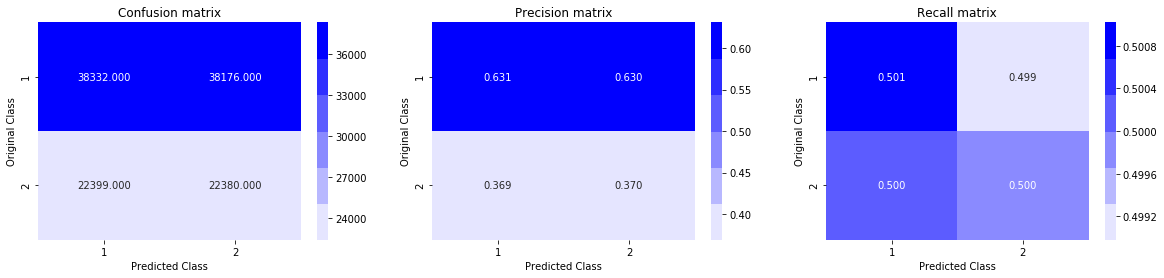

In [51]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [160]:
type(X_train)


numpy.ndarray

In [170]:
c = 0
temp = [0,0]
for i in X_train[0]:
    if type(i) == np.ndarray:
        print('true')

true
true


In [173]:
X_train[10].shape

(627,)

## Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6585376086646746
For values of alpha =  0.0001 The log loss is: 0.6585376086646746
For values of alpha =  0.001 The log loss is: 0.6585376086646746
For values of alpha =  0.01 The log loss is: 0.6585376086646746
For values of alpha =  0.1 The log loss is: 0.5727610047532683
For values of alpha =  1 The log loss is: 0.6510997217766119
For values of alpha =  10 The log loss is: 0.6199300049091271


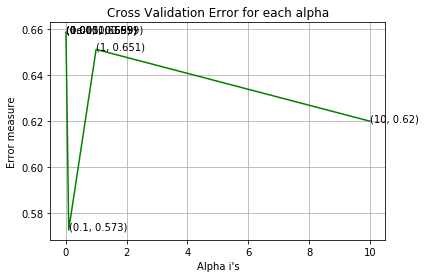

For values of best alpha =  0.1 The train log loss is: 0.57165130851402
For values of best alpha =  0.1 The test log loss is: 0.5727610047532683
Total number of data points : 121281


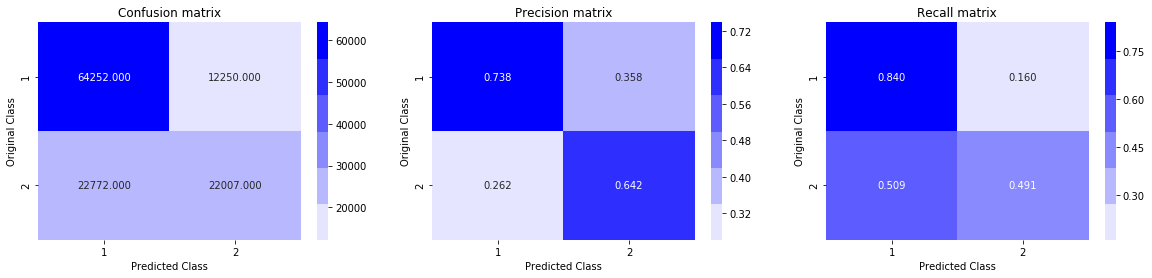

In [81]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.6585376086646746
For values of alpha =  0.0001 The log loss is: 0.6585376086646746
For values of alpha =  0.001 The log loss is: 0.6585376086646746
For values of alpha =  0.01 The log loss is: 0.6585376086646746
For values of alpha =  0.1 The log loss is: 0.6585376086646746
For values of alpha =  1 The log loss is: 0.6187268817393777
For values of alpha =  10 The log loss is: 0.6279449557722059


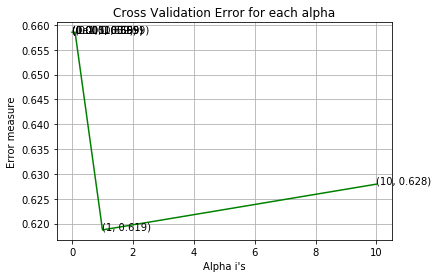

For values of best alpha =  1 The train log loss is: 0.6177395360799548
For values of best alpha =  1 The test log loss is: 0.6187268817393777
Total number of data points : 121281


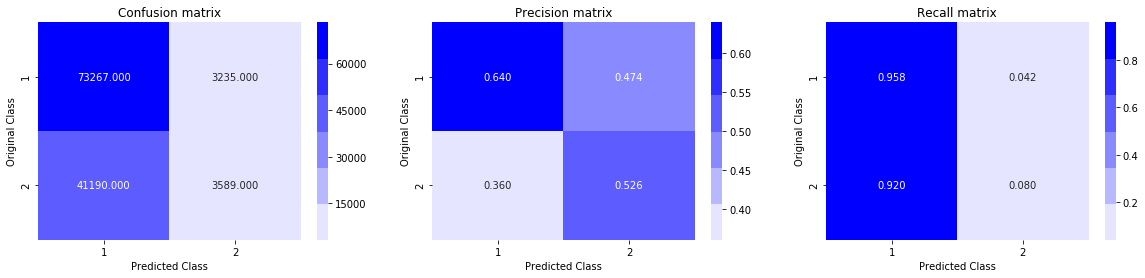

In [82]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [83]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684799	valid-logloss:0.684867
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61525	valid-logloss:0.615344
[20]	train-logloss:0.564527	valid-logloss:0.564759
[30]	train-logloss:0.526532	valid-logloss:0.526746
[40]	train-logloss:0.497094	valid-logloss:0.497379
[50]	train-logloss:0.473995	valid-logloss:0.474347
[60]	train-logloss:0.455456	valid-logloss:0.455863
[70]	train-logloss:0.440769	valid-logloss:0.441284
[80]	train-logloss:0.428494	valid-logloss:0.429098
[90]	train-logloss:0.418908	valid-logloss:0.419579
[100]	train-logloss:0.410853	valid-logloss:0.411602
[110]	train-logloss:0.403962	valid-logloss:0.404799
[120]	train-logloss:0.398286	valid-logloss:0.399166
[130]	train-logloss:0.393362	valid-logloss:0.394385
[140]	train-logloss:0.389261	valid-logloss:0.390322
[150]	train-logloss:0.3859	valid-logloss:0.387012
[160]	train-logloss:0.382857	va

Total number of data points : 121281


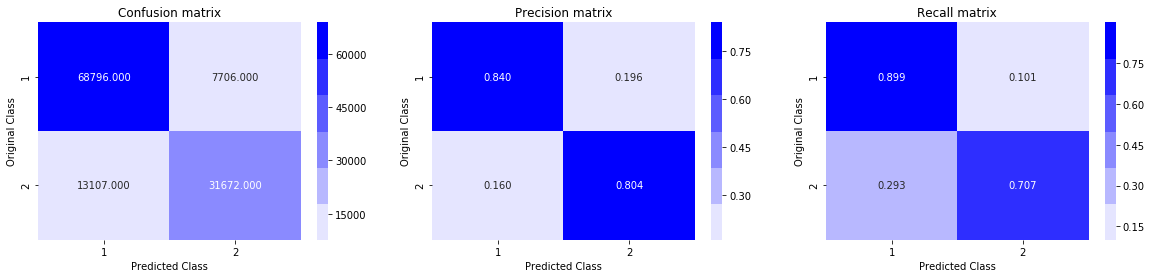

In [86]:
from sklearn.metrics import accuracy_score
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)
accuracy = accuracy_score(y_test,predicted_y)

In [87]:
print(accuracy*100)

82.83902672306462
